# Cracked Concrete Convolutional Neural Network

Matthew Karnes

March 2020

This project was completed on its own as an effort to practice and refine necessary skills.

This project will make use of Tensorflow in order to design a Convolutional Neural Network 
that will train on images of concrete that have cracks running through them and those that do not.
This is in effort to create a binary classifier that when fed an image will be able to determine 
whether the image is of cracked concrete or not.  This has applications within industry and shows that 
neural networks can be adapted to for other uses as well such as determining whether a machine is at a failing point
or that a product is not to proper standard in an assembly line.

The dataset used is from 

Özgenel, Çağlar Fırat (2019), “Concrete Crack Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/5y9wdsg2zt.2

and consists of 20,000 images of cracked concrete and 20,000 images of non-cracked concrete. 
The dataset was compiled specifically for use in creating neural networks for classification problems.
The images have already been split into two directories for training and validation and I will apply various transformations 
to the training images.  I will then build a CNN using Tensorflow's Keras Sequential Model due to its high level of convenience.
    

# Imports

Here I import the necessary modules for the CNN as well as modules for directory paths, graphing, and 
allowing use with older python versions.

In [2]:
#Required to run on older versions of python
from __future__ import absolute_import, division, print_function, unicode_literals

#Import Tensorflow
import tensorflow as tf

#Import Sequential in order to build our model
from tensorflow.keras.models import Sequential
#Import the layers to use for our model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
#Import the Image Data Generator to preprocess our images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#OS for our directory path joining
import os
#Numpy and matplotlib for graphing our CNN's progress
import numpy as np
import matplotlib.pyplot as plt

# Image Directory Paths

Here I create a path to our directory of images. The images are split into a directory of train images
and validation images. Those directories are then subdivided into "Negative" and "Positive" directories.
In total there are 20,000 negative and 20,000 positive images which are split such that there are a total of 
28,000 train images and 12,000 validation images, which are each split evenly between positive and negative images.

I start by first finding the absolute path to the directory with all of the images to use for classification.
I then create paths to the Train and Validation directories within that original directory.

In [3]:
#Get the path to the folder of our test images.
folder = os.path.abspath("Concrete Crack Images for Classification")

#Path to the Train and Validation directories
train_dir = os.path.join(folder, "Train")
validation_dir = os.path.join(folder, "Validate")

Next, I create paths to the negative and positive images within the Train and Validation
directories.

In [4]:
#Directory with our training non-cracked pictures
train_neg_dir = os.path.join(train_dir, "Negative")  

#Directory with our training cracked pictures
train_pos_dir = os.path.join(train_dir, "Positive")  

#Directory with our validation non-cracked pictures
validation_neg_dir = os.path.join(validation_dir, "Negative")  

#Directory with our validation cracked pictures
validation_pos_dir = os.path.join(validation_dir, "Positive")  

In [5]:
#Find the amount of images in each of our directories

#Number of positive and negative in the train directory
num_neg_tr = len(os.listdir(train_neg_dir))
num_pos_tr = len(os.listdir(train_pos_dir))

#Number of positive and negative in the validation directory
num_neg_val = len(os.listdir(validation_neg_dir))
num_pos_val = len(os.listdir(validation_pos_dir))

#Total images
total_train = num_neg_tr + num_pos_tr
total_val = num_neg_val + num_pos_val

In [6]:
print('total training neg images:', num_neg_tr)
print('total training pos images:', num_pos_tr)

print('total validation neg images:', num_neg_val)
print('total validation pos images:', num_pos_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training neg images: 14000
total training pos images: 14000
total validation neg images: 6000
total validation pos images: 6000
--
Total training images: 28000
Total validation images: 12000


Here I am going to set some initial conditions for our model.

- Batch size - The number of images that are looked at before the model changes its weights.
             I set the batch to 128 which will lead to 215 batches of images looked at in
             each pass through all the images.

- Epoch - This is how many times I will iterate through the entirety of the image set.  
        The more times I iterate through the images the better the CNN will learn about the images
        but more epochs can be computationally expensive.

- Image height and width - These are the dimensions that I will set for the images. The images are originally
                         of the dimensions 227 by 227.  Higher dimensions or resolutions will be more expensive 
                         to analyze so I set the dimensions to be 64 by 64 which will still allow for recognizable images
                         but that are easier to work with.

In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Image Preprocessing

I will now prepare the images to be fed into the network.  Images are made up of different colored pixels of Red, Green, and Blue
with values between 1 and 255.  These pixels need to be repackaged into a form that can be read by the network.  To do this I convert the image into a 3 dimensional tensor, and then divide each of the pixels by 255 in order to have a range between 0 and 1.  I will use the Keras ImageDataGenerator class due to its high levels of convenience. Though it is less flexible than other methods, for my purposes it should work well.

As well as rescaling and decoding the images, I will apply data augmentation methods to the train images so as to help mitigate overfitting of our data.  Augmentation applies various transformations to the train images so that the network essentially never sees the same image twice.  I will apply random horizontal flips to the images, as well as random rotations, zooms, and width / height shifts. 

In [8]:
#Read in train images, decode them, rescale, and apply image transformations
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [9]:
#Seperate images into batches, shuffle them, and resize to the target height and width
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="binary")

Found 28000 images belonging to 2 classes.


When decoding and resizing, validation data augmentations are not applied so that I may test off of real world equivalents.

In [10]:
#Decode and rescale validation data.
image_gen_val = ImageDataGenerator(rescale=1./255)

In [11]:
#Seperate validation images into batches and resize to target height and width
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode="binary")

Found 12000 images belonging to 2 classes.


I will now plot some of our train images so that I can see how the augmentations and resizing will affect the images.

In [12]:
#This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
sample_training_images, _ = next(train_data_gen)

As can be seen here the reduced resolution does make the images blurrier but the identifying feature of the crack in the positive images is easily recognizable still.

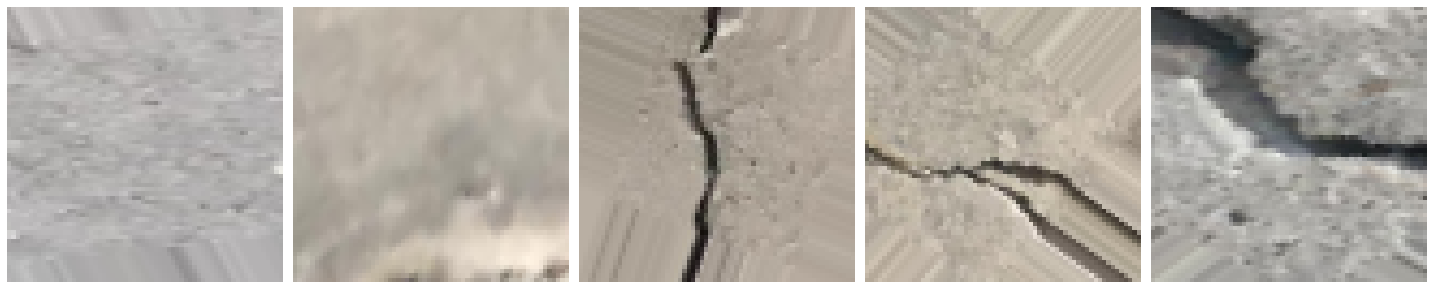

In [14]:
plotImages(sample_training_images[:5])

# Model

I will now build and compile our model using the Keras Sequential function which allows for fast and convenient model building at the cost of flexibility.  This is fine for our purposes though, as I will be implementing a relatively simple CNN.  The model will consist of three Convolutional Layers, three Max Pooling Layers, and two Dropout Layers before flattening and moving to two Fully Connected Layers for output.  I will use ReLU for the activation function and pad the data so as to not drop any information.  This CNN resembles a few of the more famous architectures, mainly AlexNet and VGG, though for the sake of computational time and needed power I am working with a CNN smaller than those architectures.  However, I should be able to maintain great results despite this.     

In [15]:
#Build the model
model = Sequential([    
    Conv2D(16, 3, padding="same", activation="relu", 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1)
])

I compile using the Adam optimizer as it is both fast and accurate and our loss is BinaryCrossentropy as I am working on a binary classification problem.

In [16]:
model.compile(optimizer="adam",
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

I then begin to fit the model to our training data and then validate on the validation data.  I train for 218 steps and validate for 93 across 15 epochs. 

In [17]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 218 steps, validate for 93 steps
Epoch 1/15
218/218 [==============================] - 139s 638ms/step - loss: 0.2530 - accuracy: 0.8566 - val_loss: 0.0549 - val_accuracy: 0.9850
Epoch 2/15
218/218 [==============================] - 148s 678ms/step - loss: 0.0652 - accuracy: 0.9797 - val_loss: 0.0672 - val_accuracy: 0.9831
Epoch 3/15
218/218 [==============================] - 152s 695ms/step - loss: 0.0560 - accuracy: 0.9817 - val_loss: 0.0419 - val_accuracy: 0.9871
Epoch 4/15
218/218 [==============================] - 148s 678ms/step - loss: 0.0514 - accuracy: 0.9830 - val_loss: 0.0553 - val_accuracy: 0.9862
Epoch 5/15
218/218 [==============================] - 150s 690ms/step - loss: 0.0464 - accuracy: 0.9849 - val_loss: 0.0420 - val_accuracy: 0.9881
Epoch 6/15
218/218 [==============================] - 153s 701ms/step - loss: 0.0434 - accuracy: 0.9861 - val_loss: 0.0299 - val_accuracy: 0.9932
Epoch 7/15
218/218 [===========

This took around 40 minutes to train which while not blazingly fast due to my machine, is still a far cry from very deep learning machines which can take weeks to train completely.  And in those 40 minutes I have a machine that is reporting an accuracy of 99%!  I will now plot the change in the loss and accuracy over the epochs.

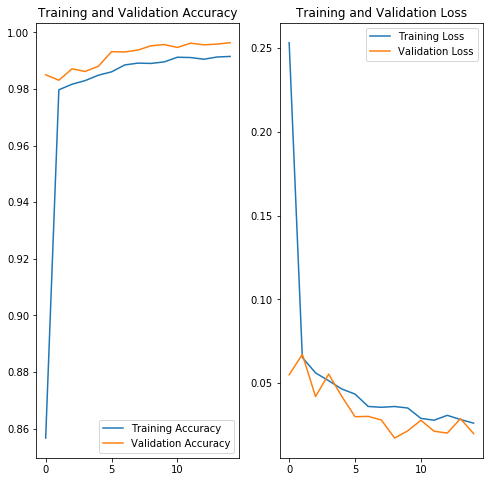

In [18]:
#Get the training and validation accuracy over time
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

#Get the training and validation loss over time
loss = history.history["loss"]
val_loss = history.history["val_loss"]

#Find the total epochs used
epochs_range = range(epochs)

#Plot the training and validation accuracy over the epochs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

#Plot the training and validation loss over the epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Conclusion

As can be seen very high accuracy and low loss was achieved quickly with seemingly low overfitting, as in the case of overfitting the validation loss and accuracy would be much less than the training loss and accuracy.  Here, the validation is actually higher in terms of accuracy and lower in terms of loss.  This is due to the use of Dropout in the model as when validating the CNN is able to use all of its power to classify the images but during training the Dropout will set certain neurons to zero in order to combat overfitting. I then save the model so that it can later be used for classification of new images as well as for further training. 

In [19]:
# Save the model
model.save('concrete_crack_model.h5')